In [1]:
# 使用models模块创建并训练神经网络模型
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

In [2]:
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

In [3]:
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 10
df = df.dropna()
df["label"].describe()

count    1.197673e+06
mean     5.759776e-03
std      2.858067e-01
min     -4.650000e+00
25%     -1.330000e-01
50%      0.000000e+00
75%      1.370000e-01
max      1.249400e+01
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 140.7571268081665


DIF       DEA    RET1_1    RET2_1    RET1_2  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.028009  0.006501 -0.007669  0.248954 -0.019697   
           000002.SZ   0.399351  0.335073 -0.020086  0.100418 -0.021490   
           000059.SZ   0.091686  0.061918  0.031250  0.832636  0.046341   
           000061.SZ   0.187649  0.071498  0.037244  0.870293  0.141393   
           000063.SZ   0.798487  0.470710 -0.038779  0.020921 -0.013166   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   4.732139  3.689427 -0.014494  0.245614  0.046560   
           688396.SH   0.072127  0.480778 -0.013770  0.266667  0.000566   
           688561.SH   0.842230  0.673733 -0.021464  0.126316 -0.030424   
           688599.SH  -1.572494 -2.529311  0.039960  0.992982  0.056604   
           688981.SH   0.029167  0.184851 -0.013983  0.256140 -0.012793   

                         RET2_2    RET1_3    RET2_3    RET1_4    RET2_4  ...  \
datetime   instrument                                                    ...   
2006-04-07 000001.SZ   0.209205 -0.015221  0.213389  0.009360  0.343096  ...   
           000002.SZ   0.167364  0.004412  0.430962 -0.008708  0.196653  ...   
           000059.SZ   0.820084  0.041262  0.723849  0.043796  0.631799  ...   
           000061.SZ   0.995816  0.205628  0.995816  0.205628  0.991632  ...   
           000063.SZ   0.288703  0.003827  0.426778 -0.013475  0.158996  ...   
...                         ...       ...       ...       ...       ...  ...   
2022-12-28 688363.SH   0.933333  0.047447  0.880702  0.040554  0.866667  ...   
           688396.SH   0.417544  0.009716  0.515789 -0.012116  0.175439  ...   
           688561.SH   0.049123 -0.022484  0.052632  0.053772  0.912281  ...   
           688599.SH   0.961404  0.163852  0.996491  0.131926  0.996491  ...   
           688981.SH   0.185965 -0.003897  0.245614 -0.004139  0.284211  ...   

                       MEAN2_10  MEAN2_20  MEAN2_30  MEAN2_60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.978529  0.958139  1.077550  0.969214  0.847906   
           000002.SZ   0.865644  0.732006  0.816881  0.651620  0.846304   
           000059.SZ   1.006254  0.878924  0.966881  0.795894  0.334477   
           000061.SZ   0.795945  0.803208  0.830703  0.782898  0.201339   
           000063.SZ   0.933128  0.867431  0.942097  0.921683  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.938007  0.802368  0.840133  0.980244  0.391778   
           688396.SH   1.089137  0.996531  1.017298  0.900445  1.674625   
           688561.SH   0.991060  0.925343  1.039368  0.684092  0.494056   
           688599.SH   0.882503  1.052199  1.064043  1.083195  0.528563   
           688981.SH   1.050083  0.996821  1.044376  0.924189  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60    label  
datetime   instrument                                                   
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  0.26700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  0.25300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -0.20700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.01800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.07900  
...                         ...       ...       ...       ...      ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.01550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.04161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.04736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.08861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.06114  

[1144693 rows x 156 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1144693 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 156 entries, DIF to label
dtypes: float64(156)
memory usage: 1.3+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


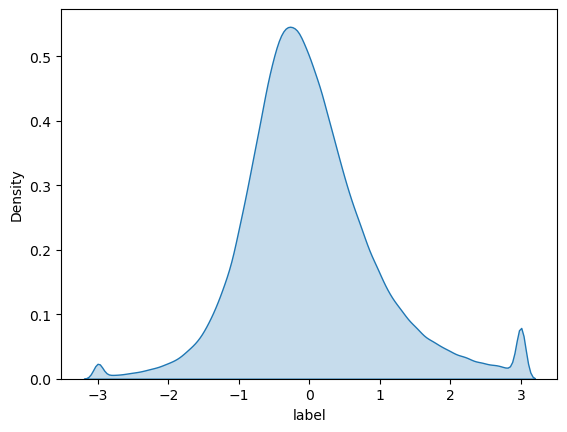

The distribution of y_valid:


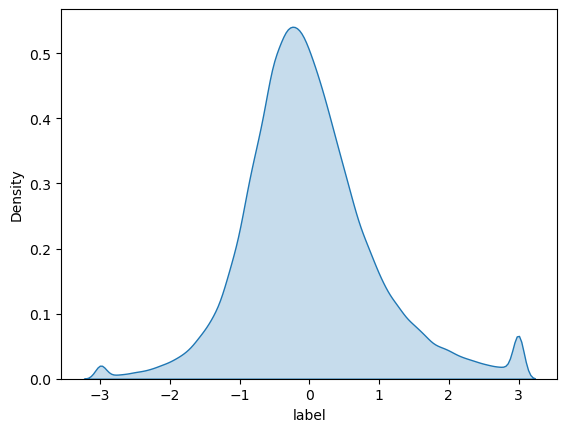

The distribution of y_test:


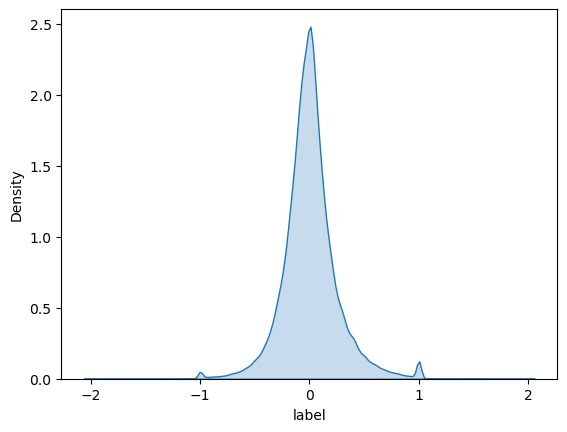

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
from scutquant import models

cnn = models.CNN()
cnn.fit(X_train, y_train, X_valid, y_valid)

pred = cnn.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)

pred.describe()

Epoch 1/10
2361/2361 [==============================] - 57s 23ms/step - loss: 0.9350 - mae: 0.7217 - mape: 1114.7843 - val_loss: 0.8946 - val_mae: 0.7058 - val_mape: 3049.0254
Epoch 2/10
2361/2361 [==============================] - 55s 23ms/step - loss: 0.8980 - mae: 0.7073 - mape: 844.3879 - val_loss: 0.9042 - val_mae: 0.7097 - val_mape: 3741.1809
Epoch 3/10
2361/2361 [==============================] - 56s 24ms/step - loss: 0.8911 - mae: 0.7045 - mape: 1015.1907 - val_loss: 0.8886 - val_mae: 0.6996 - val_mape: 2802.3093
Epoch 4/10
2361/2361 [==============================] - 57s 24ms/step - loss: 0.8865 - mae: 0.7029 - mape: 631.7438 - val_loss: 0.8843 - val_mae: 0.7017 - val_mape: 2925.3738
Epoch 5/10
2361/2361 [==============================] - 57s 24ms/step - loss: 0.8817 - mae: 0.7009 - mape: 562.5710 - val_loss: 0.8841 - val_mae: 0.6994 - val_mape: 1473.3019
Epoch 6/10
2361/2361 [==============================] - 58s 24ms/step - loss: 0.8788 - mae: 0.6995 - mape: 519.4946 - val_l

,predict
count,281836.000000
mean,0.000325
std,0.001973
min,-0.016355
25%,-0.000895
50%,0.000227
75%,0.001446
max,0.018032


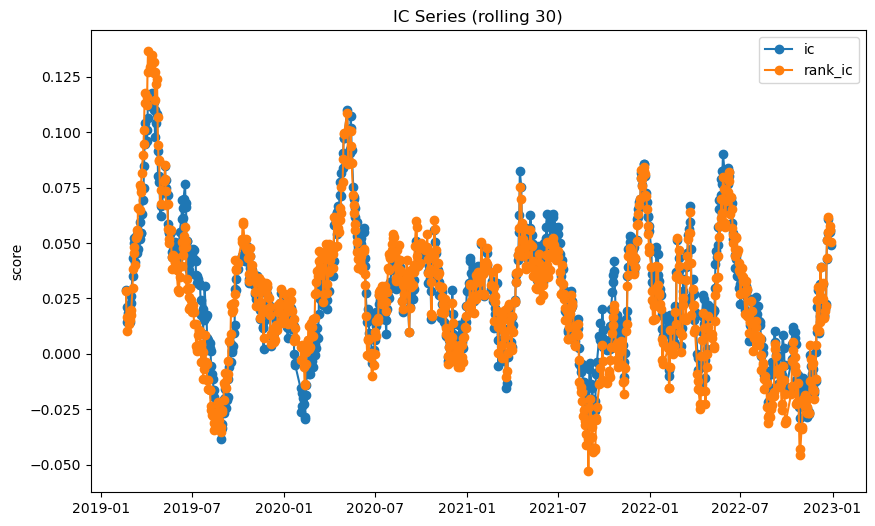

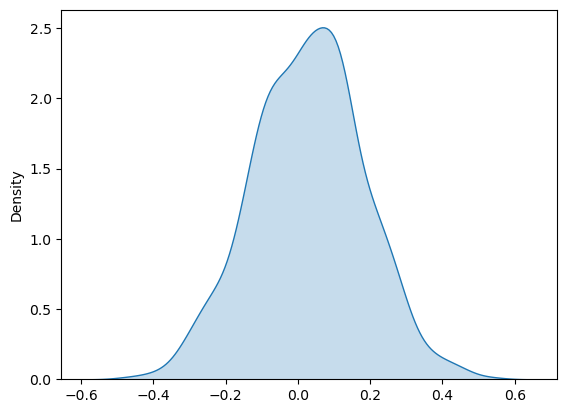

ic= 0.02781788151827975 icir= 0.180143616673326 rank_ic= 0.025272412918293952 rank_icir= 0.1571702570915119


0.029688586354719656

In [7]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred.values, y_test)
r[0]

In [8]:
model = cnn.model
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 49, 32)            320       
                                                                 
 batch_normalization (BatchN  (None, 49, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 48, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            14400     
                                                                 
 batch_normalization_1 (Batc  (None, 14, 64)           256       
 hNormalization)                                                 
                                                        

Accuracy of Prediction: 0.5283280380408129


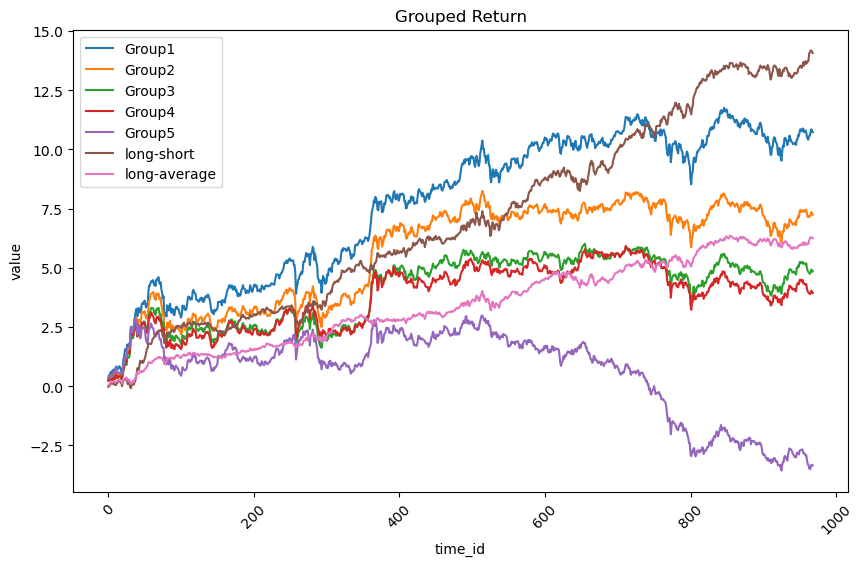

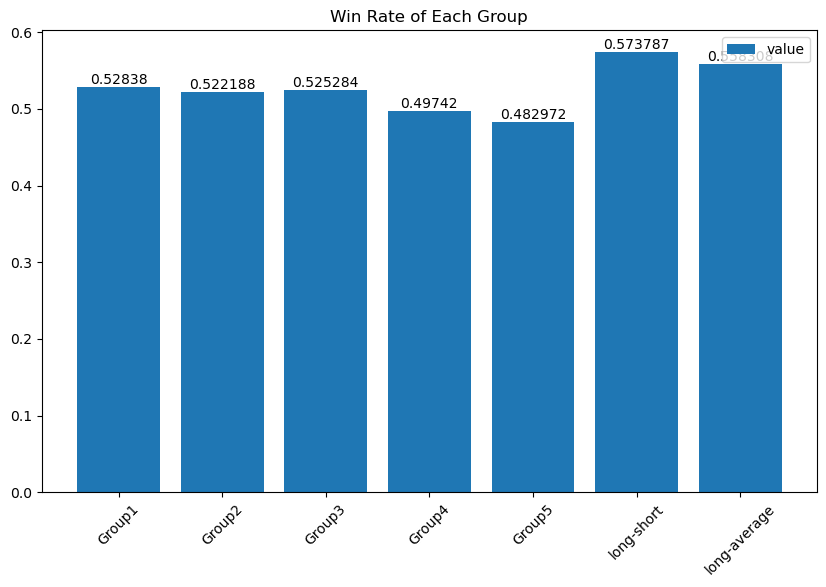

In [9]:
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')
report.group_return_ana(pred, y_test)

In [10]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "sigma": 1, 
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.12241226868643573
Annualized Volatility: 0.4029851400703066
Annualized Return(Benchmark): 0.07903465509941188
Annualized Volatility(Benchmark): 0.3391763376455748 

Cumulative Rate of Return: 0.5590065466558403
Cumulative Rate of Return(Benchmark): 0.3397659986073198
Cumulative Excess Rate of Return: 0.21924054804852044 

Max Drawdown: -0.3755130787577323
Max Drawdown(Benchmark): -0.5464988056952735
Max Drawdown(Excess Return): -0.1915812821665015 

Sharpe Ratio: 2.2594089535320188
Sortino Ratio: 0.24685177481949674
Information Ratio: 0.24196817341108934 

Beta: 1.077796789203313
Alpha: 0.017465475942047226
Epsilon: 0.0864843058826473
Profitable Days(%): 0.6945304437564499


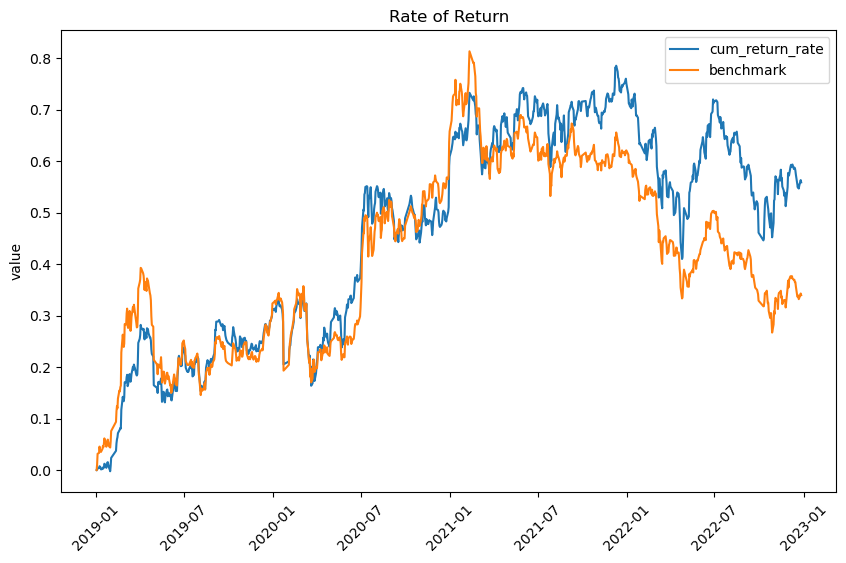

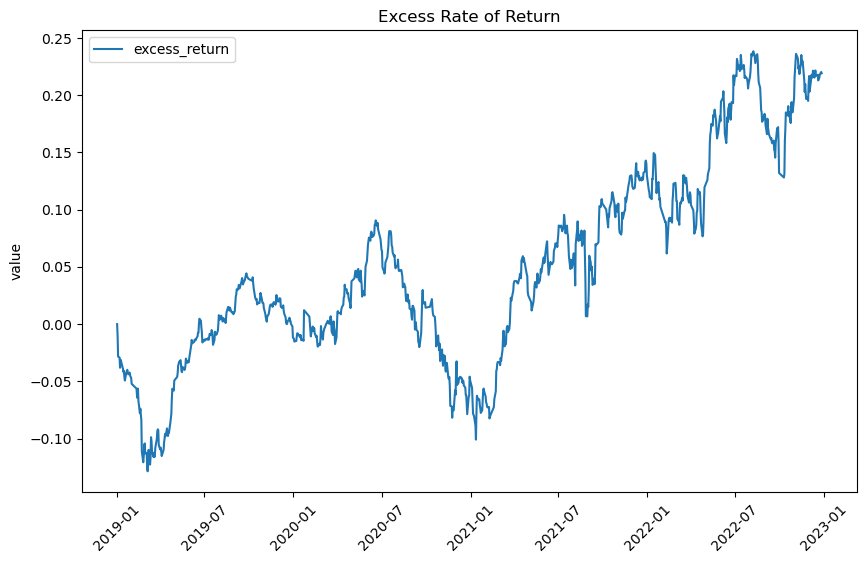

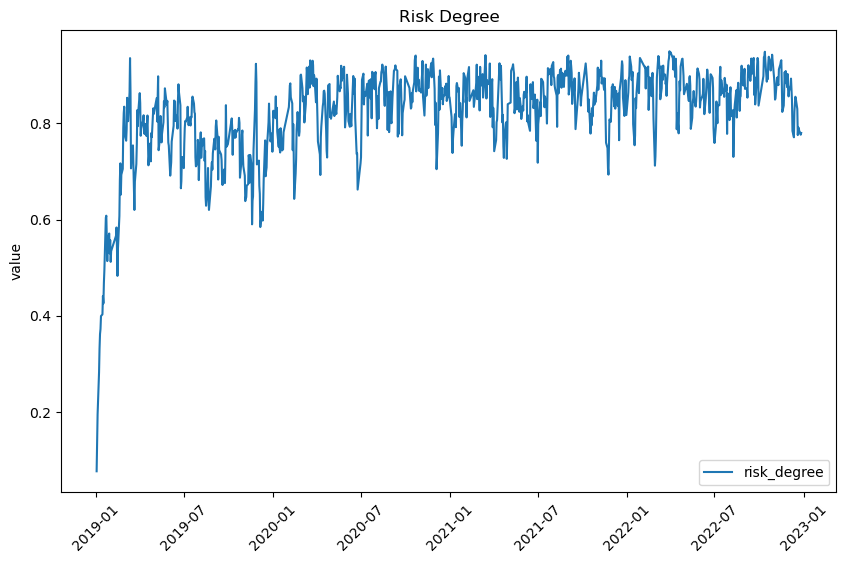

In [11]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [12]:
model.save("cnn")

INFO:tensorflow:Assets written to: cnn\assets


INFO:tensorflow:Assets written to: cnn\assets
